# ConvNets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import DL libraries and frameworks 

In [3]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


# Navigate to the input data

In [5]:
%cd /kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/

/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages


# Preprocess only when flag is true

In [6]:
# flag = True
flag = False

In [7]:
class Preprocess():
    cat = "./Cat"
    dog = "./Dog"
    labels = {cat : 0, dog : 1}
    X_train = []
    y_train = []
    
    def load_train_set(self):
        for label in self.labels:
            for file in tqdm(os.listdir(label)):
                path = label + '/' + file
                try:
                    img = plt.imread(path)[:, :, :3]
                    img = cv2.resize(img, (64, 64))
                    self.X_train.append(torch.tensor(img))
                    self.y_train.append(self.labels[label])
                except:
                    pass
        
        self.X_train = torch.stack(self.X_train)
        self.y_train = torch.tensor(self.y_train)
        
        perm = np.random.permutation(len(self.X_train))
        self.X_train = self.X_train[perm]
        self.y_train = self.y_train[perm]

In [8]:
if(flag):
    p = Preprocess()
    p.load_train_set()
    flag = False
    X_train = p.X_train
    y_train = p.y_train

In [9]:
if flag:
    torch.save(X_train, '/kaggle/working/X_train.pt')
    torch.save(y_train, '/kaggle/working/y_train.pt')

In [10]:
X = torch.load('/kaggle/input/catsanddogs/X_train.pt').permute(0, 3, 1, 2)
y = torch.load('/kaggle/input/catsanddogs/y_train.pt')

# Test, Validation & Train Split

In [11]:
X = torch.FloatTensor(X / 255.0)
y = torch.tensor(y, dtype = torch.long)

In [12]:
val = int(len(X) * 0.05)
test = int(len(X) * 0.05)

X_val = X[:val]
y_val = y[:val]

X_test = X[val : (val + test)]
y_test = y[val : (val + test)]

X_train = X[(val + test):]
y_train = y[(val + test):]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([22460, 3, 64, 64]) torch.Size([22460])
torch.Size([1247, 3, 64, 64]) torch.Size([1247])
torch.Size([1247, 3, 64, 64]) torch.Size([1247])


In [13]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

batch_size = 128

data_train = TensorDataset(X_train, y_train)
train_dl = DataLoader(data_train, batch_size = batch_size)

data_val = TensorDataset(X_val, y_val)
valid_dl = DataLoader(data_val, batch_size = batch_size)

data_test = TensorDataset(X_test, y_test)
test_dl = DataLoader(data_test, batch_size = batch_size)

# Create the Model Graph

In [14]:
check = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(16, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 256, 3, padding  = 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2))

x = torch.randn(1, 3, 64, 64)
check(x).shape

torch.Size([1, 256, 1, 1])

# Creating the Model

In [15]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(16, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 256, 3, padding  = 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
) 

In [16]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)

# Training the Model

In [17]:
def train(model, criterion, optimiser):
    model.train()
    avg_loss = 0
    
    for X_batch, y_batch in tqdm(train_dl):
        model.zero_grad()
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimiser.step()
        
        loss = loss.cpu().detach().numpy()
        avg_loss += loss.item()
        
        del X_batch, y_batch, pred, loss
        torch.cuda.empty_cache()
        
    avg_loss /= len(data_train)
    return avg_loss

In [18]:
def evaluate(model, criterion):
    model.eval()
    avg_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(valid_dl):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            
            loss = loss.cpu().detach().numpy()
            avg_loss += loss.item()
            correct += torch.sum(torch.argmax(pred, axis = 1) == y_batch).item()
            
#             del X_batch, y_batch, pred, loss
#             torch.cuda.empty_cache()
            
    avg_loss /= len(data_val)
    acc = correct / len(data_val)
    del correct
    
    return avg_loss, acc

In [19]:
def fit(model, criterion, optimiser, epochs = 5):
    
    train_loss_rec = []
    val_loss_rec = []
    val_acc_rec = []
    max_acc = 0
    best_model = model
    
    for epoch in range(epochs):
        train_loss = train(model, criterion, optimiser)
        train_loss_rec.append(train_loss)
        
        val_loss, val_acc = evaluate(model, criterion)
        val_loss_rec.append(val_loss)
        val_acc_rec.append(val_acc)
        
        print(f"Train Loss: {train_loss}  Val Loss: {val_loss}  Val Acc: {val_acc}")
        
        if max_acc < val_acc:
            best_model = model
            max_acc = val_acc
            
    plt.plot(train_loss_rec)
    plt.plot(val_loss_rec)
    plt.show()
    
    plt.plot(val_acc_rec)
    plt.show()
    
    return max_acc, best_model

In [20]:
def test(model):
    correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_dl):
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            correct += torch.sum(torch.argmax(pred, axis = 1) == y_batch).item()
            
            del X_batch, y_batch, pred
            torch.cuda.empty_cache()
            
    test_acc = correct / len(data_test)
    del correct
    
    return test_acc

In [21]:
print(evaluate(model, criterion))


(0.005612275317466632, 0.5108259823576584)



Train Loss: 0.0052253775053117705  Val Loss: 0.005128485064747435  Val Acc: 0.627906976744186



Train Loss: 0.004853261315918138  Val Loss: 0.004807359998285436  Val Acc: 0.6607858861267041



Train Loss: 0.004375579770080553  Val Loss: 0.004279643177699354  Val Acc: 0.7297514033680834



Train Loss: 0.003846336110351559  Val Loss: 0.00381894876886198  Val Acc: 0.7738572574178028



Train Loss: 0.0035083571861921838  Val Loss: 0.0035570185234189127  Val Acc: 0.7898957497995188



Train Loss: 0.003230267943597116  Val Loss: 0.0033138249765516953  Val Acc: 0.8147554129911788



Train Loss: 0.002966321688991302  Val Loss: 0.003142005673579053  Val Acc: 0.8235765838011226



Train Loss: 0.0026781617971477186  Val Loss: 0.0030422621520882908  Val Acc: 0.8412189254210104


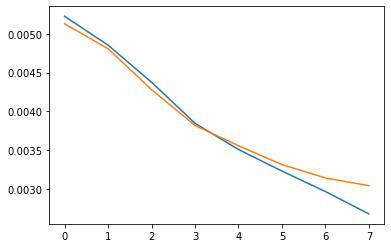

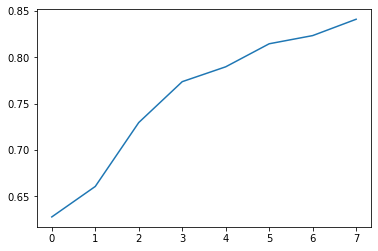

In [22]:
max_acc, model = fit(model, criterion, optimiser, epochs = 8)

In [23]:
max_acc

0.8412189254210104


Train Loss: 0.0022574940678113716  Val Loss: 0.0028629404311191586  Val Acc: 0.8476343223736968



Train Loss: 0.002156885424736665  Val Loss: 0.002838953576665357  Val Acc: 0.8460304731355253



Train Loss: 0.0020956843912283015  Val Loss: 0.002826535245276683  Val Acc: 0.8460304731355253



Train Loss: 0.0020422619867834363  Val Loss: 0.002820794546040135  Val Acc: 0.8492381716118684



Train Loss: 0.0019923257089998715  Val Loss: 0.002816340592544176  Val Acc: 0.8524458700882117


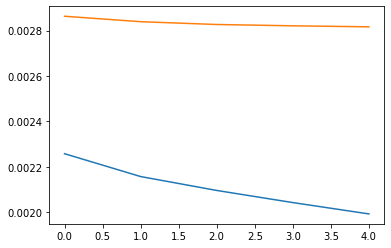

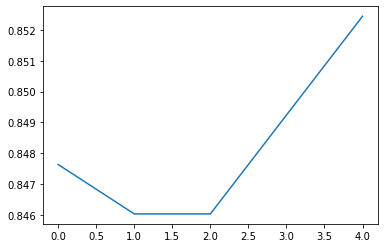

In [24]:
optim = optim.Adam(model.parameters(), lr = 1e-4)
max_acc, model = fit(model, criterion, optim)

In [25]:
evaluate(model, criterion)

(0.002816340592544176, 0.8524458700882117)

# Testing the Model 

In [26]:
test(model)

0.846832397754611